# Explore the NDVI Data

In [1]:
from pathlib import Path
import os
import warnings

%load_ext autoreload
%autoreload

# ignore warnings for now ...
warnings.filterwarnings('ignore')

if Path('.').absolute().parents[1].name == 'ml_drought':
    os.chdir(Path('.').absolute().parents[1])

!pwd

/Users/tommylees/github/ml_drought


In [2]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

data_dir = Path('data/')
# data_dir = Path('/Volumes/Lees_Extend/data/zip_data')
data_dir = Path('/Volumes/Lees_Extend/data/ecmwf_sowc/data/')

assert data_dir.exists()

In [3]:
import seaborn as sns
from src.utils import drop_nans_and_flatten

## Open data and initial explore

In [4]:
vci = xr.open_dataset(data_dir / 'interim' / 'VCI_preprocessed' / 'data_kenya.nc')
vci = vci.sortby('lat')
vci

<xarray.Dataset>
Dimensions:  (lat: 45, lon: 35, time: 454)
Coordinates:
  * time     (time) datetime64[ns] 1981-08-31 1981-09-30 ... 2019-05-31
  * lon      (lon) float64 33.75 34.0 34.25 34.5 34.75 ... 41.5 41.75 42.0 42.25
  * lat      (lat) float64 -5.0 -4.75 -4.5 -4.25 -4.0 ... 5.0 5.25 5.5 5.75 6.0
Data variables:
    VCI      (time, lat, lon) float64 39.36 18.57 19.15 12.16 ... 0.0 30.86 0.0

In [5]:
p = xr.open_dataset(
    data_dir / 'interim' / 'chirps_preprocessed' / 'data_kenya.nc'
)
p

<xarray.Dataset>
Dimensions:  (lat: 45, lon: 35, time: 464)
Coordinates:
  * time     (time) datetime64[ns] 1981-01-31 1981-02-28 ... 2019-08-31
  * lon      (lon) float32 33.75 34.0 34.25 34.5 34.75 ... 41.5 41.75 42.0 42.25
  * lat      (lat) float32 6.0 5.75 5.5 5.25 5.0 ... -4.0 -4.25 -4.5 -4.75 -5.0
Data variables:
    precip   (time, lat, lon) float64 ...

In [6]:
ds = xr.open_dataset(
    data_dir / 'interim' / 'ndvi_preprocessed' / 'data_kenya.nc'
)
ds

<xarray.Dataset>
Dimensions:  (lat: 45, lon: 35, time: 458)
Coordinates:
  * time     (time) datetime64[ns] 1981-06-30 1981-07-31 ... 2019-07-31
  * lon      (lon) float32 33.75 34.0 34.25 34.5 34.75 ... 41.5 41.75 42.0 42.25
  * lat      (lat) float32 6.0 5.75 5.5 5.25 5.0 ... -4.0 -4.25 -4.5 -4.75 -5.0
Data variables:
    ndvi     (time, lat, lon) float64 ...

### errors in some months:
- 2018-05-31
- 2016-08-31

In [7]:
valid_times = [
    t for t in ds.time.values
    if not np.isin(
        pd.to_datetime(t), 
        [pd.to_datetime('2018-05-31'), pd.to_datetime('2016-08-31')]
    )
]
ds = ds.sel(time=valid_times)

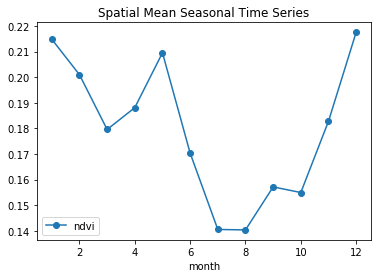

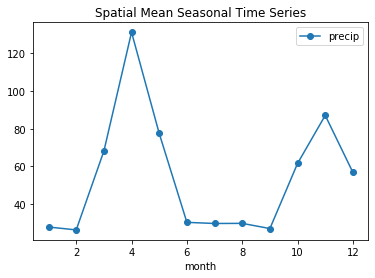

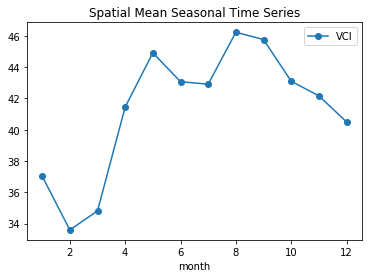

In [8]:
from scripts.drafts.plotting_utils import plot_seasonality, plot_normalised_seasonality

fig, ax = plt.subplots()
plot_seasonality(ds, ax=ax);
fig, ax = plt.subplots()
plot_seasonality(p, ax=ax);
fig, ax = plt.subplots()
plot_seasonality(vci, ax=ax);

## Plot the Spatial Seasonality

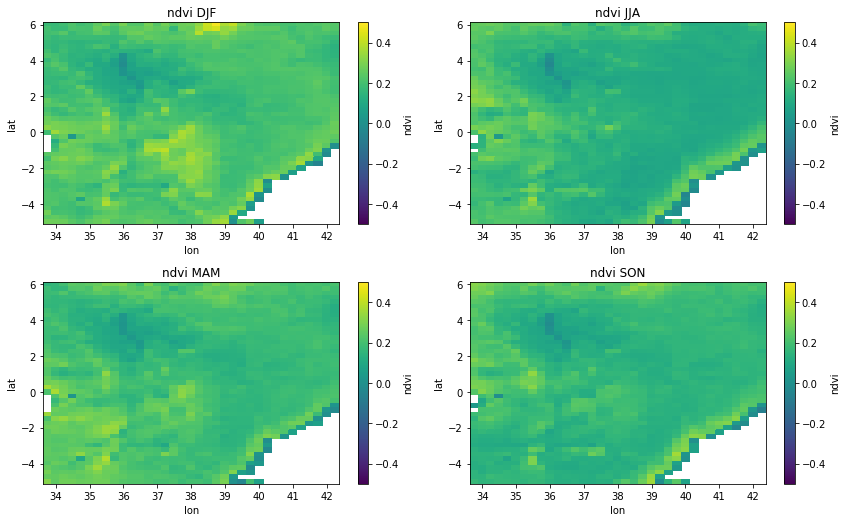

In [9]:
from scripts.drafts.plotting_utils import plot_seasonal_spatial_means

seas = (
    ds
    .groupby('time.season')
    .mean(dim=['time']).ndvi
)

plot_seasonal_spatial_means(seas, **{'vmin':-0.5, 'vmax':0.5});

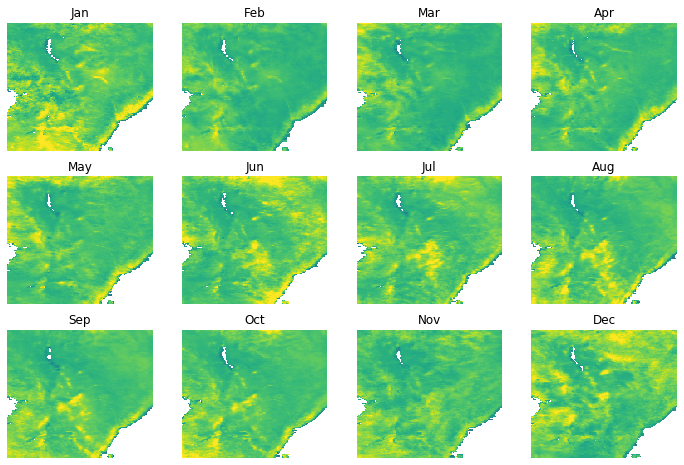

In [155]:
import calendar
# ds.groupby('time.month').mean(dim='time')

fig, axs = plt.subplots(3, 4, sharex=True, sharey=True, figsize=(12, 8))
for i in range(0, 12):
    ax_ix = np.unravel_index(i, (3, 4))
    ax = axs[ax_ix]
    ds.ndvi.isel(time=i).plot(ax=ax, add_colorbar=False, vmin=-0.4, vmax=0.4)
    ax.set_title(calendar.month_abbr[i+1])
    ax.axis('off')

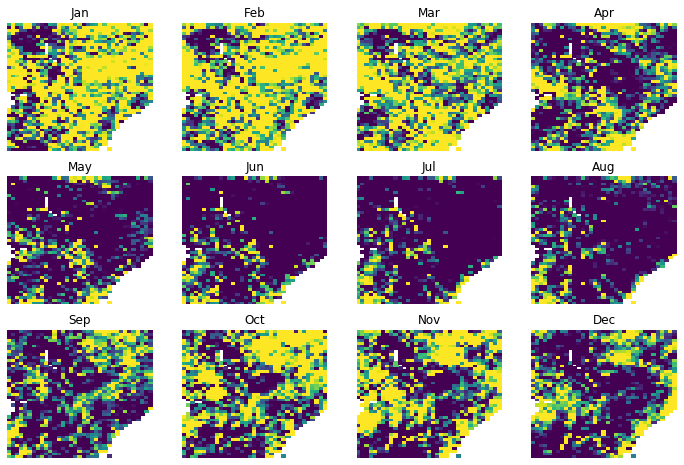

In [156]:
fig, axs = plt.subplots(3, 4, sharex=True, sharey=True, figsize=(12, 8))
for i in range(0, 12):
    ax_ix = np.unravel_index(i, (3, 4))
    ax = axs[ax_ix]
    vci.VCI.isel(time=i).plot(ax=ax, add_colorbar=False, vmin=30, vmax=70)
    ax.set_title(calendar.month_abbr[i+1])
    ax.axis('off')

## Dynamic plotting to find errored timesteps
### errors in some months:
- 2018-05-31
- 2016-08-31

FROM THESE DAYS: (INVERTED LATITUDES...)
**2018-05-28**
**2016-08-26**

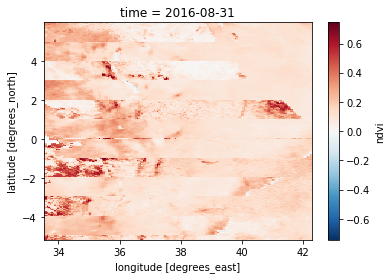

In [109]:
# (ds
#  .sel(time=ds.time.dt.season == 'JJA')
#  .isel(time=slice(-7, -1))
#  .ndvi.mean(dim='time').plot()
# )

(ds
 .sel(time=ds.time.dt.season == 'JJA')
 .isel(time=-9)
 .ndvi.plot()
)

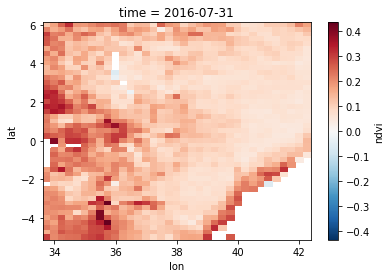

In [10]:
(ds
 .sel(time=ds.time.dt.season == 'JJA')
 .isel(time=-9)
 .ndvi.plot()
)

In [50]:
# ds.loc[~]
(ds.sel(lat=slice(-5,-4), lon=slice(41,42)).ndvi.isnull().mean(dim=['lat', 'lon']) == 1)
(ds.sel(lat=slice(-4, -5), lon=slice(41,42)).ndvi.isnull())

<xarray.DataArray 'ndvi' (time: 456, lat: 5, lon: 5)>
array([[[ True,  True, ...,  True,  True],
        [ True,  True, ...,  True,  True],
        ...,
        [ True,  True, ...,  True,  True],
        [ True,  True, ...,  True,  True]],

       [[ True,  True, ...,  True,  True],
        [ True,  True, ...,  True,  True],
        ...,
        [ True,  True, ...,  True,  True],
        [ True,  True, ...,  True,  True]],

       ...,

       [[ True,  True, ...,  True,  True],
        [ True,  True, ...,  True,  True],
        ...,
        [ True,  True, ...,  True,  True],
        [ True,  True, ...,  True,  True]],

       [[ True,  True, ...,  True,  True],
        [ True,  True, ...,  True,  True],
        ...,
        [ True,  True, ...,  True,  True],
        [ True,  True, ...,  True,  True]]])
Coordinates:
  * time     (time) datetime64[ns] 1981-06-30 1981-07-31 ... 2019-07-31
  * lon      (lon) float32 41.0 41.25 41.5 41.75 42.0
  * lat      (lat) float32 -4.0 -4.25 -4.5 -4.

In [54]:
from src.utils import region_lookup, Region
# (lonmin, lonmax, latmin, latmax) = (41, 42, -5, -4, )


def _fix_invalid_timesteps(ds: xr.Dataset, 
                           region_of_known_nans: Region, 
                           variable: str, 
                           drop: bool = True) -> xr.Dataset:
    """in the region_of_known_nans if the values are 
    NON-NAN then that timestep has an error.
    
    We currently drop these values (safest). However, we 
    are working on functionality to check for and invert 
    latitudes.
    """
    latmin = region_of_known_nans.latmin
    latmax = region_of_known_nans.latmax
    lonmin = region_of_known_nans.lonmin
    lonmax = region_of_known_nans.lonmax
    
    # create a boolean DataArray of the timesteps that are ALL NAN
    # inside that bounding box.
    boolean_da = (
        ds.sel(lat=slice(latmax, latmin), lon=slice(lonmin, lonmax))[variable]
        .isnull().mean(dim=['lat', 'lon']) == 1
    )
    invalid_times = ds.sel(time=~boolean_da).time.values
    if list(invalid_times) != []:
        print(f'Invalid timesteps for variable {variable} removed:')
        print(invalid_times)
    else:
        print(f'All timesteps for variable: {variable} valid! None removed.')
    return ds.sel(time=boolean_da)

In [55]:
subset_str = 'indian_ocean'

region = region_lookup[subset_str] if subset_str is not None else None
_fix_invalid_timesteps(ds, region, variable='ndvi')
_fix_invalid_timesteps(dd, region, variable='ndvi')

<xarray.Dataset>
Dimensions:  (lat: 45, lon: 35, time: 456)
Coordinates:
  * time     (time) datetime64[ns] 1981-06-30 1981-07-31 ... 2019-07-31
  * lon      (lon) float32 33.75 34.0 34.25 34.5 34.75 ... 41.5 41.75 42.0 42.25
  * lat      (lat) float32 6.0 5.75 5.5 5.25 5.0 ... -4.0 -4.25 -4.5 -4.75 -5.0
Data variables:
    ndvi     (time, lat, lon) float64 ...

In [69]:
region_of_known_nans = region
variable = 'ndvi'
latmin = region_of_known_nans.latmin
latmax = region_of_known_nans.latmax
lonmin = region_of_known_nans.lonmin
lonmax = region_of_known_nans.lonmax
boolean_da = (
    ds.sel(lat=slice(latmax, latmin), lon=slice(lonmin, lonmax))[variable]
    .isnull().mean(dim=['lat', 'lon']) == 1
)
boolean_da

list(ds.sel(time=~boolean_da).time.values)

[]

In [ ]:
def create_kenya_xarray(variable='precip'):
    pass

ds = create_kenya_xarray()
ds.sel(lat=slice(latmax, latmin), lon=slice(lonmin, lonmax))

In [72]:
d.sel(lat=slice(latmax, latmin), lon=slice(lonmin, lonmax)) == np.nan

In [73]:
from src.utils import region_lookup, Region

In [74]:
region_lookup

{'kenya': Region(name='kenya', lonmin=33.501, lonmax=42.283, latmin=-5.202, latmax=6.002),
 'ethiopia': Region(name='ethiopia', lonmin=32.9975838, lonmax=47.9823797, latmin=3.397448, latmax=14.8940537),
 'east_africa': Region(name='east_africa', lonmin=21, lonmax=51.8, latmin=-11, latmax=23),
 'indian_ocean': Region(name='indian_ocean_box', lonmin=41, lonmax=42, latmin=-5, latmax=-4)}

# Write the tests

In [146]:
%autoreload 2

from tests.utils import _make_dataset
import pytest
import numpy as np

from src.utils import region_lookup
from src.preprocess.base import BasePreProcessor

In [147]:
def _make_dataset_with_invalid_data():
    size = (50, 50)
    ds, _, _ = _make_dataset(size, lonmin=33.501, lonmax=42.283,
                             latmin=-5.202, latmax=6.002)
    ds = ds.astype('float64')

    lc = ds.coords['lon']
    la = ds.coords['lat']

    region = region_lookup['indian_ocean']
    latmin = region.latmin
    latmax = region.latmax
    lonmin = region.lonmin
    lonmax = region.lonmax

    ds.VHI.loc[
        dict(
            lon=lc[(lc > lonmin) & (lc < lonmax)],
            lat=la[(la > latmin) & (la < latmax)]
        )
    ] = np.nan

    errored_time_values = np.ones(size)

    # create 3 errored timesteps
    ds.VHI.loc['2000-01-31'] = errored_time_values
    ds.VHI.loc['2000-08-31'] = errored_time_values
    ds.VHI.loc['2001-08-31'] = errored_time_values

    return ds

In [148]:
ds = _make_dataset_with_invalid_data()
ds

<xarray.Dataset>
Dimensions:  (lat: 50, lon: 50, time: 36)
Coordinates:
  * lat      (lat) float64 -5.202 -4.973 -4.745 -4.516 ... 5.545 5.773 6.002
  * lon      (lon) float64 33.5 33.68 33.86 34.04 ... 41.75 41.92 42.1 42.28
  * time     (time) datetime64[ns] 1999-01-31 1999-02-28 ... 2001-12-31
Data variables:
    VHI      (time, lat, lon) float64 0.0 23.0 54.0 89.0 ... 73.0 64.0 65.0 64.0

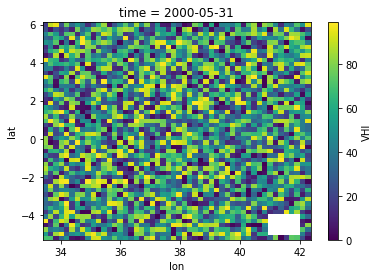

In [149]:
# ds.sel(time='2000-01-31').VHI.plot()
ds.sel(time='2000-05-31').VHI.plot()

In [150]:
p = BasePreProcessor(data_dir)

A dataset attribute must be added for the interim and out directories to be created


In [157]:
out_ds = p._fix_invalid_timesteps(ds=ds, variable='VHI', subset_str='indian_ocean', invert_lat=False)

Invalid timesteps for variable VHI removed:
['2000-01-31T00:00:00.000000000' '2000-08-31T00:00:00.000000000'
 '2001-08-31T00:00:00.000000000']


In [152]:
subset_str = 'indian_ocean'
variable = 'VHI'
invert_lat = False

region_of_known_nans = region_lookup[subset_str]

latmin = region_of_known_nans.latmin
latmax = region_of_known_nans.latmax
lonmin = region_of_known_nans.lonmin
lonmax = region_of_known_nans.lonmax

# create a boolean DataArray of the timesteps that are ALL NAN
# inside that bounding box.
if invert_lat:
    boolean_da = (
        ds.sel(lat=slice(latmax, latmin), lon=slice(lonmin, lonmax))[variable]
        .isnull().mean(dim=['lat', 'lon']) == 1
    )
else:
    boolean_da = (
        ds.sel(lat=slice(latmin, latmax), lon=slice(lonmin, lonmax))[variable]
        .isnull().mean(dim=['lat', 'lon']) == 1
    )



# boolean_da
# (
#     ds.sel(lat=slice(latmin, latmax), lon=slice(lonmin, lonmax))[variable]
#     .values
# )

invalid_times = ds.sel(time=~boolean_da).time.values
if list(invalid_times) != []:
    print(f'Invalid timesteps for variable {variable} removed:')
    print(invalid_times)
else:
    print(f'All timesteps for variable: {variable} valid! None removed.')

ds.sel(time=boolean_da)


Invalid timesteps for variable VHI removed:
['2000-01-31T00:00:00.000000000' '2000-08-31T00:00:00.000000000'
 '2001-08-31T00:00:00.000000000']


<xarray.Dataset>
Dimensions:  (lat: 50, lon: 50, time: 33)
Coordinates:
  * lat      (lat) float64 -5.202 -4.973 -4.745 -4.516 ... 5.545 5.773 6.002
  * lon      (lon) float64 33.5 33.68 33.86 34.04 ... 41.75 41.92 42.1 42.28
  * time     (time) datetime64[ns] 1999-01-31 1999-02-28 ... 2001-12-31
Data variables:
    VHI      (time, lat, lon) float64 0.0 23.0 54.0 89.0 ... 73.0 64.0 65.0 64.0